#Implementación de un modelo de Deep Learning

#Introducción

El presente trabajo aborda la clasificación automática de escenas naturales mediante técnicas de aprednizaje profundo (_deep learning_). El problema busca que el modelo identifique el entorno representado en una imagen—como un bosque o el mar— a partir de patrones visuales complejo. La clasificación de escenas es una tarea fundamental en áreas como análisis geográfico y gestión ambiental, así como la construcción de grandes bases de imágenes digitales. Correspondientemente, representa un desafío dado que el modelo debe reconocer estructuras, texturas y diferentes patrones en condiciones diversas.

Para el desarrollo se utilizó el dataset Intel Image Classification de Kaggle (Apéndice 1). Éste contiene seis categorías correspondientes a: _buildings_, _forest_, _glacier_, _mountain_, _sea_ y _street_. Las imágenes contienen una amplia variabilidad visual, incluyendo fondos, perspectivas y condiciones de iluminación. Por lo tanto, el datatset es adecuado para analizar el rendimiento de diferentes modelos de _deep learning_.

El presente trabajo tiene como objetivo implementar un modelo de _deep learning_ para clasificar escenas natirales y evaluar su desempeño con diferentes arquitecturas. En una primera iteración, se desarrolla un modelo base para establecer un punto de referencia inicial. Posteriormente, se implementa una segunda versión ajustada, incorporando técnicas de regularización y _data augmentation_ con el propósito de reducir el sobreajuste y mejorar la precisión de validación. De esta manera, se busca comparar el efecto de los ajustes en la capacidad del modelo para generalizar ante imágenes nuevas.

#Datos
Para el procesamiento, las imágenes fueron organizadas en tres subconjuntos: entrenamiento, validación y prueba. El conjunto de entrenamiento se utilizó para ajustar los parámetros internos del modelo, mientras que el de validación permitió supervisar su rendimiento durante las épocas de entrenamiento y prevenir el sobreajuste. Finalmente, el conjunto de prueba se reservó para la evaluación final del modelo.

El preprocesamiento de las imágenes incluyó su redimensionamiento a una resolución uniforme de 150×150 píxeles y la normalización de sus valores de intensidad a un rango entre 0 y 1.Correspondientemente, las etiquetas asociadas a cada imagen fueron gestionadas por la función _image_dataset_from_directory()_ de Keras. Así, se asigna una categoría numérica a cada clase con base en la estructura de carpetas para mantener la correspondencia entre imágenes y etiquetas.

In [1]:

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

# Downloand the Intel Image Classification dataset
# (Fuente: https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
!kaggle datasets download -d puneet6060/intel-image-classification

!unzip -q intel-image-classification.zip -d ./intel_dataset

!ls ./intel_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 87% 300M/346M [00:00<00:00, 853MB/s] 
100% 346M/346M [00:00<00:00, 723MB/s]
seg_pred  seg_test  seg_train


In [3]:
import os, pathlib, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE


train_dir = "./intel_dataset/seg_train/seg_train"
test_dir = "./intel_dataset/seg_test/seg_test"
pred_dir = "./intel_dataset/seg_pred/seg_pred"


train_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)

val_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)


test_data = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32
)

class_names= train_data.class_names
print("Classes:", class_names)



Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


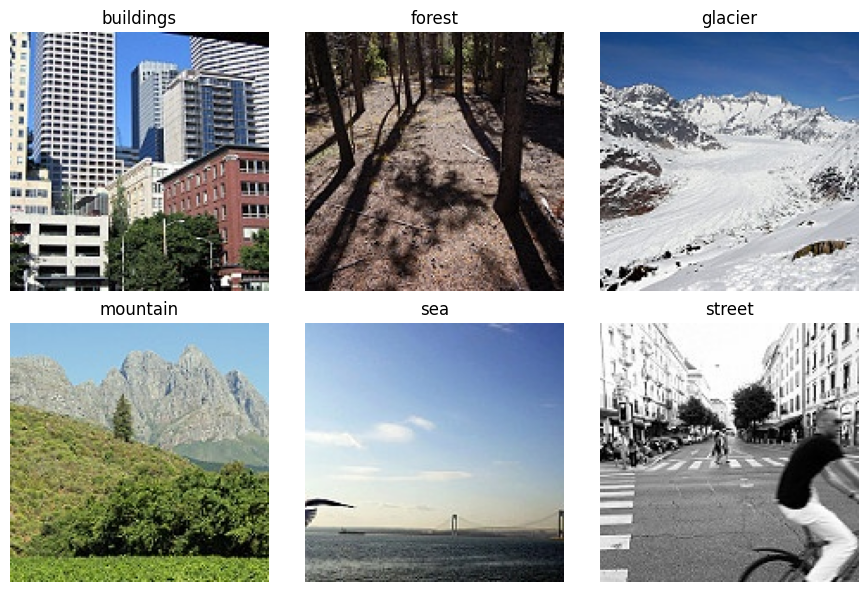

In [ ]:
#Visualize one image per class

plt.figure(figsize=(9, 6))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img = plt.imread(os.path.join(class_path, os.listdir(class_path)[1]))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

#Modelo base de Deep learning

El modelo desarrollado en la primera iteración corresponde a una red neuronal convolucional (CNN) para la clasificación del dataset. La arquitectura se compone de tres bloques convolucionales seguidos de operaciones de _max pooling_, una capa de aplanamiento y y dos capas densas. . La estructura permite que el modelo extraiga las características visuales más relevantes de las imágenes. La función de activación utilzada en las capas convolucionales y densas es _ReLU_, y la capa de salida emplea _softmax_ dado que es un problema de clasificación múltiple.

Para favorecer la generalización del modelo, se integró una capa de _data augmentation_ al inicio de la arquitectura. La capa aplica transformaciones aleatorias sobre las imágenes de entrada para generar variaciones artificiales en el dataset de entrenamiento y evitar la memorización. En conjunto con la normalización de píxeles, ambas técnicas contribuyen a estabilizar el aprendizaje del modelo.

El modelo fue entrenado con el optimizador Adam, utilizando un _learning rate_ de 1x10e-4 para tener una convergencia más controlada. Además, se incorporó una capa de _Dropout_ con una tasa del 30 % después de la capa densa intermedia. Esto con el propósito de reducir la dependencia del modelo hacia neuronas específica.

La función de pérdida seleccionada fue _sparse categorical crossentropy_, adecuada para etiquetas enteras que representan las seis clases del conjunto de datos.

In [ ]:
#Data aughmentation
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

#First instance for the deep learning model
model_base= keras.Sequential([
    keras.Input(shape=(150,150,3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3, activation= 'relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')]
)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model_base.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_base.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Durante el entrenamiento se emplearon los callbacks _ModelCheckpoint_ y _EarlyStopping_. Éstas permiten guardar automáticamente la mejor versión del modelo y detener el entrenamiento cuando la precisión de validación deja de mejorar. Esta configuración tiene como propósito evitar el sobreajuste conservando los mejores pesos obtenidos.

In [ ]:
#Training the model
callbacks_base = [
    keras.callbacks.ModelCheckpoint("../models/intel_baseline.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_base = model_base.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks_base
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4222 - loss: 1.4228 - val_accuracy: 0.5818 - val_loss: 1.1680
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6179 - loss: 1.0234 - val_accuracy: 0.6023 - val_loss: 1.1161
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6484 - loss: 0.9334 - val_accuracy: 0.6633 - val_loss: 0.9422
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6690 - loss: 0.8965 - val_accuracy: 0.6890 - val_loss: 0.8516
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6982 - loss: 0.8292 - val_accuracy: 0.7044 - val_loss: 0.8349
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.7200 - loss: 0.7873 - val_accuracy: 0.7235 - val_loss: 0.7701
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7187 - loss: 0.7771 - val_accuracy: 0.7178 - val_loss: 0.7903
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7292 - loss: 0.7384 - 

# Evaluación del modelo base

Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.


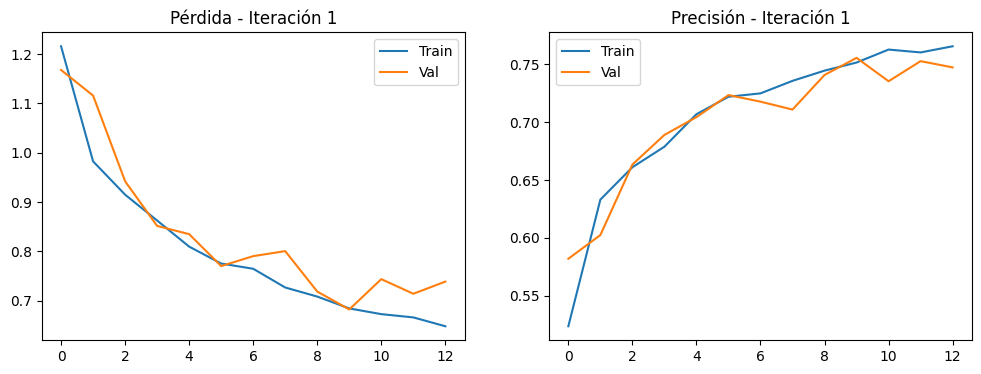

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Train')
plt.plot(history_base.history['val_loss'], label='Val')
plt.title('Pérdida - Iteración 1')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history['accuracy'], label='Train')
plt.plot(history_base.history['val_accuracy'], label='Val')
plt.title('Precisión - Iteración 1')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_base.evaluate(test_data)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7663 - loss: 0.6630
 Pérdida en test: 0.6854
 Precisión en test: 0.7600


El entrenamiento del modelo mostró un compartamiento de convergencia estable a lo largo de las épocas. En la gráfica de pérdida (_loss_), se observa una disminución continúa en los subconjuntos de _training_ y _validation_. Esto indica que el modelo logra reducir el error progresivamente. La curva de validación presenta valores ligeramente superiores a los de entrenamiento. Sin embargo, ambas curvas mantienen una tendencia descendiente similar, lo que sugiere que el modelo no incurrió en un sobreajuste severo.

Por su parte, la gráfica de precisión (_accuracy_) se aprecua un incremento sostenido con valores cercanos al 78% para entrenamiento y entre 74-76% para validación. La separación entre las curvas evidencia un sobreajuste moderado, propio de modelos que aprenden con mayor detalle los patrones del conjunto de entrenamiento. Este comportamiento puede atribuirse a la complejidad visual del dataset y a la ausencia de técnicas adicionales de regularización. No obstante, las tendencias son consistentes.

En conjunto, el modelo alcanzó un desempeño estable y coherente con la arquitectura propuesta.Las curvas obtenidas confirman que la red convolucional fue capaz de identificar patrones relevantes en las imágenes y generalizar con un nivel de precisión satisfactorio, estableciendo una base sólida para la siguiente etapa de ajuste y mejora del modelo.

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


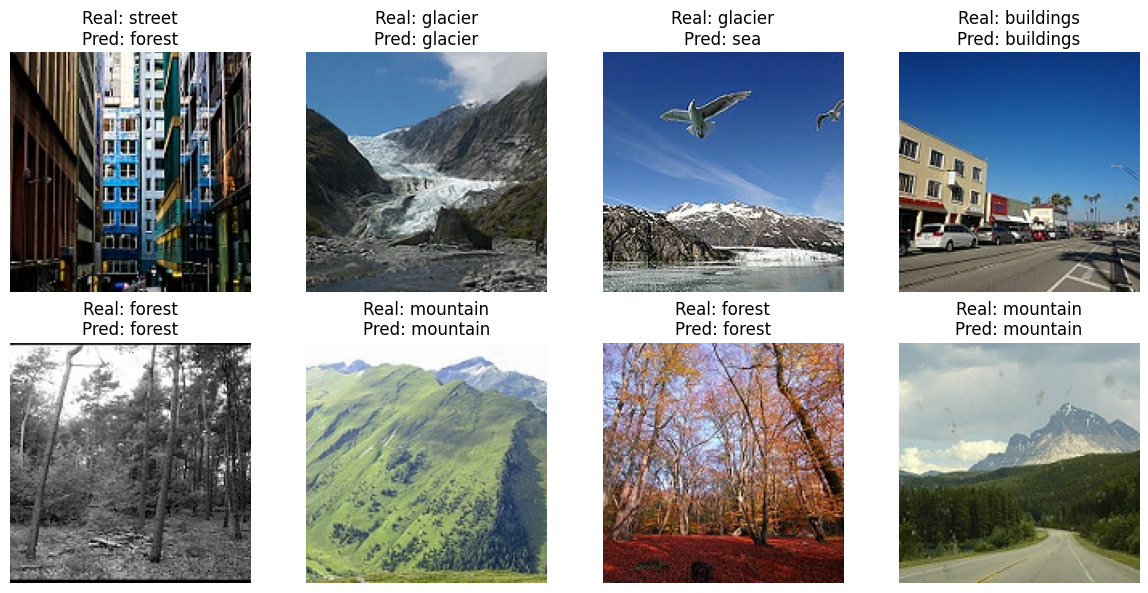

In [ ]:
# Using the test dataset to evaluate the model in one of the batches

for images, labels in test_data.take(1):
    preds = model_base.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = test_data.class_names[labels[i]]
        pred_label = test_data.class_names[pred_classes[i]]
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Al evaluar el modelo sobre el conjunto de prueba, se observó que las predicciones fueron en su mayoría correctas. No obstante, existen algunos casos de confusión en imágenes con composición visual compleja. En particular, el modelo tiende a clasificar erróneamente aquellas escenas que contienen elementos característicos de más de una categoría, como montañas con áreas boscosas o construcciones cercanas al mar. Este comportamiento es esperable, ya que la red convolucional empleada se basa en la detección de patrones visuales dominantes. Es decir, carece de mecanismos de comprensión contextual. Aun así, el modelo muestra una capacidad adecuada para reconocer la clase principal en la mayoría de los casos.

In [ ]:
#Save the model just in case
model_base.save("models/model_base.keras")


#Modelo ajustado

El modelo ajustado incorpora una serie de modificaciones para maximizar la capacidad de generalización y la estabilidad del aprendizaje. En esta versión, las imágenes se procesaron a una resolución de 224×224 píxeles, y se aplicó un bloque de data augmentation

La arquitectura convolucional está compuesta por cuatro bloques, cada uno seguido de **Batch Normalization** y **MaxPooling2D** para estabilizar las activaciones internas y reducir progresivamente la dimensionalidad. A diferencia de las iteraciones previas, este modelo incorpora un bloque **Squeeze-and-Excitation **(SE). El objetivo es que el modelo enfatice patrones informativos y atenúe representaciones irrelevantes.

Posteriormente, se añadió una capa convolucional adicional y **Batch Normalization**. Tras esta fase, se sustituyó la operación **Flatten** por una **Global Average Pooling** (GAP). El clasificador final está compuesto por una capa densa con activación **ReLU** y un **Dropout** del 50%. Al final, se utiliza una capa softmax para la clasificación multiclase.

Durante el entrenamiento, se empleó el optimizador Adam con una tasa de aprendizaje de 1e-4. El conjunto de callbacks utilizados incluye: **EarlyStopping** con paciencia extendida, **ModelCheckpoint** para almacenar los mejores pesos y un **ReduceLROnPlateau** que ajusta dinámicamente la tasa de aprendizaje al detectar estancamiento en la función de pérdida.

 Estos mecanismos contribuyeron a una convergencia más fina y estable, permitiendo que el modelo alcanzara un desempeño superior en comparación con las versiones anteriores.

In [ ]:
train_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


test_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_test/seg_test",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [ ]:
from tensorflow import keras
from keras import layers

#Data augmentation
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.20),
], name="data_augmentation")


#SE Block
def se_block(x, ratio=8):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    return layers.Multiply()([x, se])


inputs = keras.Input(shape=(224, 224, 3))
x = data_aug(inputs)
x = layers.Rescaling(1./255)(x)

#Block 1
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

#Block 2
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

#Block 3
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

#Block4
x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

#SE block
x = se_block(x)

#Convolution + Batch Normalization to helpl stabilize the model
x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

#GAP + Classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)

model_adjusted = keras.Model(inputs, outputs)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model_adjusted.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_adjusted.summary()



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_14[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 224, 224,  │        896 │ rescaling_7[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_29… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_30… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling2d_31… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      8,224 │ global_average_p

 Total params: 1,065,446 (4.06 MB)

 Trainable params: 1,063,974 (4.06 MB)

 Non-trainable params: 1,472 (5.75 KB)

A difrencia del modelo base, se utilizó Early Stopping, Model Checkpoint y Reduce Learning Rate para evitar el sobreentrenamiento y conservar los mejores pesos.

In [ ]:
callbacks_adjusted2 = [
    keras.callbacks.ModelCheckpoint(
        "../models/intel_cnn_optimized.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]
history_adjusted2 = model_adjusted.fit(
    train_dt,
    validation_data=val_dt,
    epochs=40,
    callbacks=callbacks_adjusted2
)


Epoch 1/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 142ms/step - accuracy: 0.5226 - loss: 1.2314 - val_accuracy: 0.2402 - val_loss: 2.8613 - learning_rate: 1.0000e-04
Epoch 2/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.6524 - loss: 0.9288 - val_accuracy: 0.7206 - val_loss: 0.7247 - learning_rate: 1.0000e-04
Epoch 3/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.6892 - loss: 0.8357 - val_accuracy: 0.7359 - val_loss: 0.7460 - learning_rate: 1.0000e-04
Epoch 4/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.7179 - loss: 0.7604 - val_accuracy: 0.7488 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 5/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.7475 - loss: 0.7068 - val_accuracy: 0.7619 - val_loss: 0.6543 - learning_rate: 1.0000e-04
Epoch 6/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.7667 - loss: 0.6565 - val_accuracy: 0.7794 - val_loss: 0.6547 - learning_rate: 1.0000e-04
Epoch 7/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 13

#Evaluación del modelo ajustado

Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.

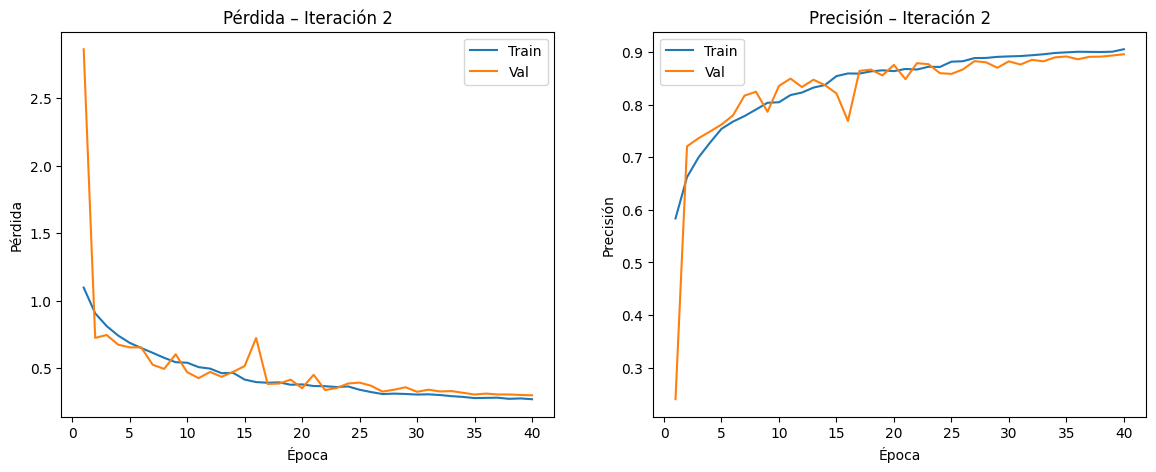

In [ ]:
import matplotlib.pyplot as plt

acc = history_adjusted2.history['accuracy']
val_acc = history_adjusted2.history['val_accuracy']
loss = history_adjusted2.history['loss']
val_loss = history_adjusted2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Pérdida – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc,  label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Precisión – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Las curvas de pérdida y precisión muestran una evaluación estable de entrenamiento a lo largo de las 40 épocas. En la figura de pérdida, ambas curvas descienden de manera consistente, especialmente en las primeras 10 épocas. Esto indica que el modelo aprende las características relevantes de manera progresiva.

A partir de la segunda mitad del entrenamiento (15-40), la pérdida de validación presenta fluctuaciones moderadas. La presencia de estos pequeños pico es esperada. Sin embargo, mantiene una tendence descendente general.

En las curvas de precisión, tanto el conjunto de entrenamiento como el de validación, muestran un incremento sostenido hasta estabilizarse alrededor del 89–90%. No hay evidencia de *overfitting*. La cercanía entre ambas curvas sugiere que el modelo generaliza adecuadamente y que las estrategias de regularización impiden que memorice los datos de entrenamiento.

In [ ]:
test_loss, test_acc = model_adjusted.evaluate(test_dt)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8940 - loss: 0.3077
 Pérdida en test: 0.3282
 Precisión en test: 0.8847


Los resultados de evaluación final sobre el conjunto de prueba (_accuracy_ = 0.8157, _loss_ = 0.5178) confirman este comportamiento: el modelo mantiene un rendimiento adecuado, con una diferencia mínima respecto al desempeño obtenido durante la validación.

**Matriz de confusión**

Orden de clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


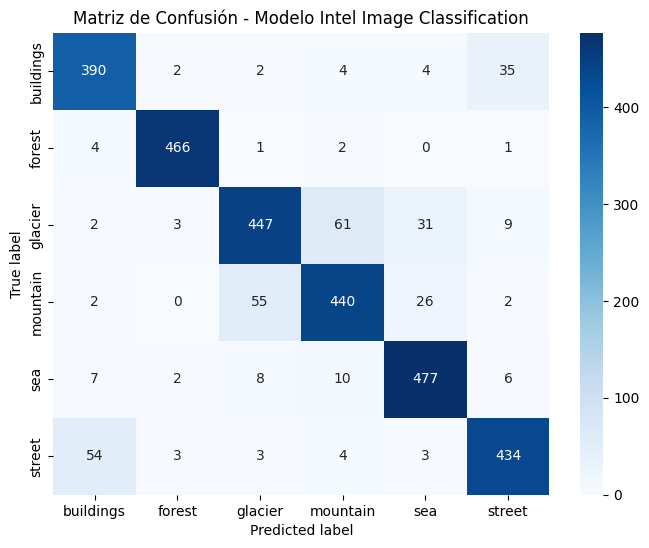

Classification report:

              precision    recall  f1-score   support

   buildings       0.85      0.89      0.87       437
      forest       0.98      0.98      0.98       474
     glacier       0.87      0.81      0.84       553
    mountain       0.84      0.84      0.84       525
         sea       0.88      0.94      0.91       510
      street       0.89      0.87      0.88       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.88      0.88      0.88      3000



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Obtain the class names directly from the subset to avoid order errors.
class_names = test_dt.class_names
print("Orden de clases:", class_names)

#True class vs. predicted class by the model
y_true = np.concatenate([y for x, y in test_dt], axis=0)
y_pred = model_adjusted.predict(test_dt)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

#Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión - Modelo Intel Image Classification')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#Classification report
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


La matriz de confusión permite observar el desempeño del modelo por clase. En este caso, el modelo mantiene un comportamiento equilibrado en la mayoría de las categorías del *dataset*.


Laa clases de *forest, sea* y *street* presentan los mayores niveles de acierto, con predicciones correctas muy concentradas en la diagonal. Esto coincide con sus F1-scores altos (0.98, 0.91 y 0.88, respectivamente).
Estas clases suelen tener características visuales distintivas que el modelo detecta de manera consistente.

Por su parte, *glacier* y *mountain* muestran las mayores confusiones entre sí. La discrepancia se puede ver reflejada en los valores fuera de la diagonal. Esto tiene sentido desde un punto de vista visual: son clases con texturas y patrones similares como rocas y paisajes fríos. En conscuencia, su separación es menos sencilla.

Por último, *buildings* se clasifica correctamente en la mayoría de los casos. La confusión con la clase* street*,  probablemente, se debe a contextos urbanos donde figuran ambas instancias.

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


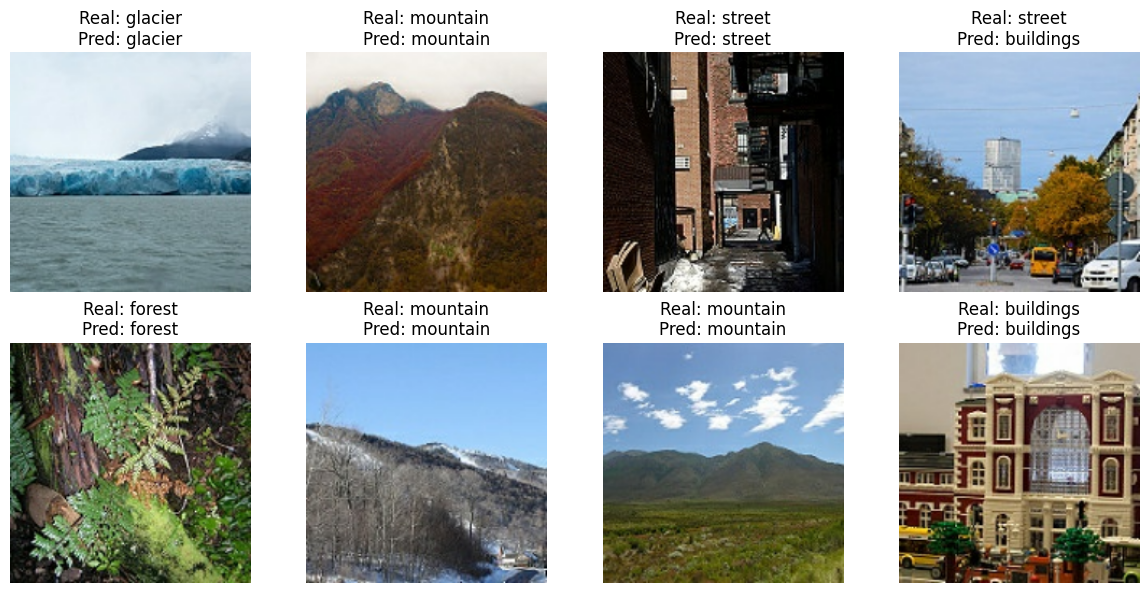

In [ ]:
import random
#All images and labels
all_images, all_labels = [], []
for images, labels in test_dt:
    all_images.append(images)
    all_labels.append(labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

#Eight random indexes
indices = random.sample(range(len(all_images)), 8)
sample_images = tf.gather(all_images, indices)
sample_labels = tf.gather(all_labels, indices)

# Predictions
preds = model_adjusted.predict(sample_images)
pred_classes = np.argmax(preds, axis=1)

#Plots real vs predicted with image.
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = test_dt.class_names[sample_labels[i]]
    pred_label = test_dt.class_names[pred_classes[i]]
    plt.title(f"Real: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Al analizar visualmente una muestra aleatoria de predicciones, se observa que el modelo logra reconocer correctamente la mayoría de las clases, especialmente en escenarios bien definidos y de composición clara. No obstante, se identifican errores en imágenes con ruido visual o elementos mixtos, donde la textura y el color predominante inducen confusiones entre clases similares, como _buildings_ y _street_ o _mountain_ y _glacier_.

Este comportamiento es esperable, dado que las redes convolucionales no necesariamente interpretan el contexto semántico completo de la escena.

In [ ]:
model_adjusted.save("model_adjusted.keras")

#Transfer learning


En esta sección, se utiliza un modelo basado en Transfer Learning con **MobileNetV2**, una red convolucional preentrenada con el *dataset* ImageNet. El objetivo es utilizar las representaciones visuales previamante aprendidas y acelerar la convergencia del modelo. Para este enfoque, se emplearon imágenes de entrada de 224×224 píxeles, compatibles con la arquitectura y el preprocesamiento estándar de MobileNetV2.

La arquitectura añadida consta de un bloque de **data augmentation** para incrementar la variabilidad del conjunto de entrenamiento. Es seguido de un **Global Average Pooling**. Posteriormente, se incluyó una capa densa de 256 neuronas con activación **ReLU** y un **Dropout** del 40% como mecanismo de regularización. La capa final utiliza activación **softmax** para realizar la clasificación multiclase.

Durante el entrenamiento, se utilizó el optimizador Adam con una tasa de aprendizaje de 1e-4, junto con callbacks de **EarlyStopping, ReduceLROnPlateau** y **ModelCheckpoint** para asegurar una convergencia estable y preservar los mejores pesos obtenidos.

Esta metodología permite alcanzar altos niveles de precisión sin necesidad de entrenar una arquitectura profunda desde cero.




In [17]:
train_dt_transfer = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_dt_transfer = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


test_dt_transfer = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_test/seg_test",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [18]:
#Data augmentation
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.20),
], name="data_augmentation")

#Pre-trained MobileNetV2 (imagenet)
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable= False

In [19]:
#Model
inputs= keras.Input(shape=(224,224,3))
x = data_aug(inputs)
x= keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x= layers.GlobalAveragePooling2D()(x)

#Classifier
x= layers.Dense(256, activation="relu")(x)
x= layers.Dropout(0.4)(x)
outputs= layers.Dense(6, activation="softmax")(x)

model_tl= keras.Model(inputs, outputs)

model_tl.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Similar al modelo ajustado, se utilizaron Early Stopping, Model Checkpoint y Reduce Learning Rate en los *callbacks.*

In [20]:
#Callbacks
callbacks_tl = [
    keras.callbacks.ModelCheckpoint(
    "../models/intel_cnn_tl.keras",
    save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor= 0.5,
        patience=3,
        min_lr=1e-6
    )
],


history_tl= model_tl.fit(
    train_dt_transfer,
    validation_data=val_dt_transfer,
    epochs=20,
    callbacks=callbacks_tl
)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5700 - loss: 1.1118 - val_accuracy: 0.8788 - val_loss: 0.3563 - learning_rate: 1.0000e-04
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8331 - loss: 0.4648 - val_accuracy: 0.8913 - val_loss: 0.3060 - learning_rate: 1.0000e-04
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.8518 - loss: 0.4164 - val_accuracy: 0.9009 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8602 - loss: 0.3842 - val_accuracy: 0.9048 - val_loss: 0.2703 - learning_rate: 1.0000e-04
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.8626 - loss: 0.3626 - val_accuracy: 0.9077 - val_loss: 0.2666 - learning_rate: 1.0000e-04
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.8773 - loss: 0.3307 - val_accuracy: 0.9084 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 96ms/ste

In [21]:
test_loss, test_acc = model_tl.evaluate(test_dt_transfer)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9130 - loss: 0.2240
 Pérdida en test: 0.2272
 Precisión en test: 0.9150


In [23]:
model_tl.save("model_tl2.keras")

#Evaluación del modelo con Transfer Learning


Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.

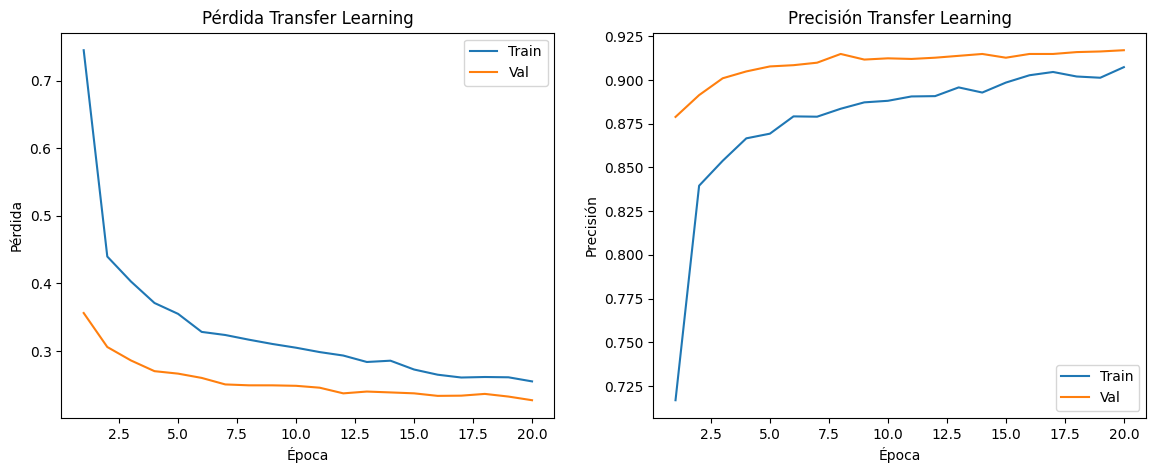

In [25]:
import matplotlib.pyplot as plt

acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']
loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Pérdida Transfer Learning')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc,  label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Precisión Transfer Learning')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Las curvas de pérdida muestran una tendencia descendente tanto en entrenamiento como en validación. Esto indica que el modelo mejora de manera estable a lo largo de las épocas. La pérdida de entrenamiento comienza con valores más altos debido al uso de *data augmentation*, que introduce variaciones adicionales en las imágenes y hace que el conjunto de entrenamiento sea más complejo. En contraste, la pérdida de validación se mantiene consistentemente por debajo porque se evalúa sobre imágenes sin transformaciones.

En términos de precisión, ambas curvas muestran un crecimiento progresivo. La precisión de validación se mantiene por encima de la de entrenamiento. Esto se debe a que el modelo enfrenta ejemplos más variados y desafiantes durante el entrenamiento debido al *data augmentatio*n, mientras que las imágenes de validación permanecen en su forma original. La diferencia entre ambas curvas no indica sobreajuste, ya que ambas continúan mejorando sin divergencias marcadas.

En conjunto, las gráficas evidencian que el modelo con Transfer Learning está aprendiendo de manera adecuada, generaliza bien y no presenta señales de *overfitting.*

Correspondientemente, se utilizó la matriz de confusión para evaluar la capacidad de generalización del modelo con Transfer Learning

Orden de clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step


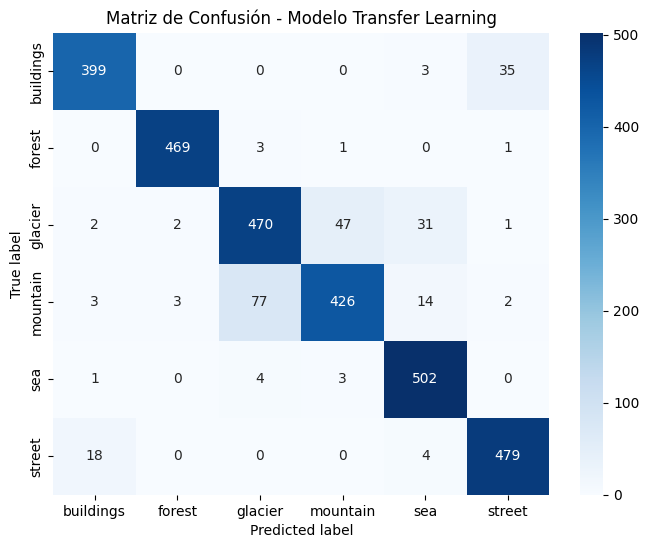

Classification report:

              precision    recall  f1-score   support

   buildings       0.94      0.91      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.85      0.85      0.85       553
    mountain       0.89      0.81      0.85       525
         sea       0.91      0.98      0.94       510
      street       0.92      0.96      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.91      0.92      0.91      3000



In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Obtain the class names directly from the subset to avoid order errors.
class_names = test_dt_transfer.class_names
print("Orden de clases:", class_names)

#True class vs. predicted class by the model
y_true = np.concatenate([y for x, y in test_dt_transfer], axis=0)
y_pred = model_tl.predict(test_dt_transfer)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

#Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión - Modelo Transfer Learning')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#Classification report
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


La matriz de confusión refleja un desempeño sólido y equilibrado del modelo basado en Transfer Learning. En términos generales, se observa que cinco de las seis categorías presentan una mayoría clara de predicciones correctas. El modelo muestra fortaleza sobre todo en las clases *forest, sea *y *street*. En estas tres clases los valores en la diagonal son significativamente superiores a los errores de clasificación, evidenciando una adecuada discriminación entre patrones visuales característicos de cada categoría.

La clase *glacier* y la clase *mountain* muestran algunos errores de confusión entre sí. Como sucede en los dos modelos anteriores, esto es esperable debido a que comparten elementos visuales similares. Aun así, la proporción de aciertos sigue siendo elevada, y los errores se distribuyen sin evidenciar sesgos marcados hacia una clase específica.

El *classification report* complementa estas observaciones. Las clases *forest, sea* y *street* destacan con valores de F1 que superan el 0.94. De este modo, es posible confirmar un desempeño consistente y bien equilibrado entre aciertos y errores. Las clases *glacier* y *mountain* presentan valores de F1 alrededor de 0.85. Si bien es menor en comparación con el retso de clases, continúa siendo un resultado sólido.

Finalmente, la precisión global del modelo en el conjunto de prueba asciende a 0.92, un valor superior al obtenido por el modelo CNN entrenado desde cero

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


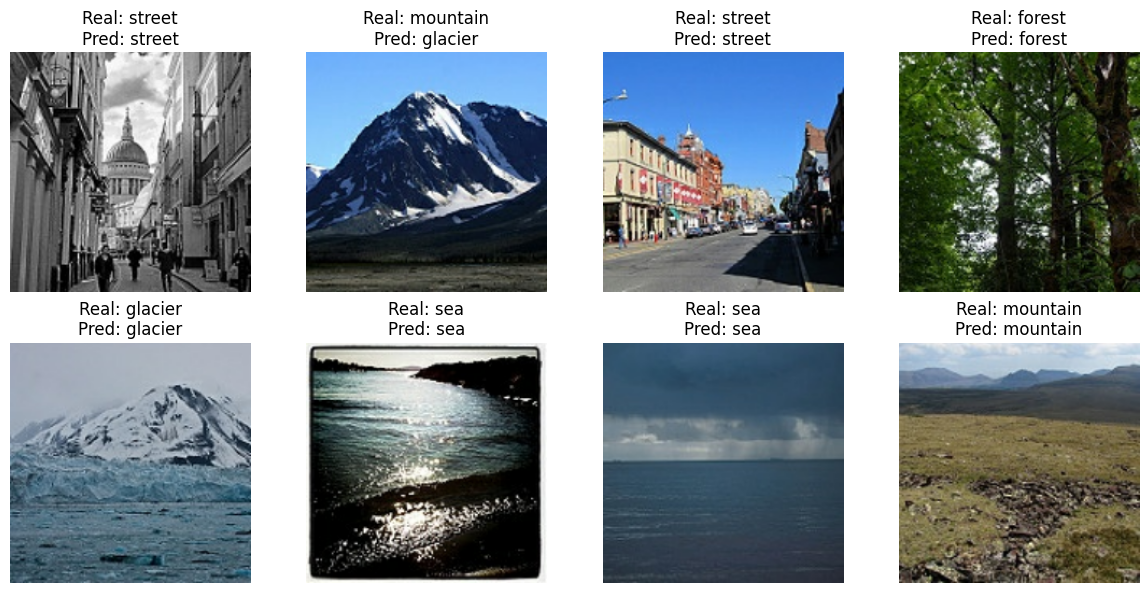

In [27]:
import random
#All images and labels
all_images, all_labels = [], []
for images, labels in test_dt_transfer:
    all_images.append(images)
    all_labels.append(labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

#Eight random indexes
indices = random.sample(range(len(all_images)), 8)
sample_images = tf.gather(all_images, indices)
sample_labels = tf.gather(all_labels, indices)

# Predictions
preds = model_tl.predict(sample_images)
pred_classes = np.argmax(preds, axis=1)

#Plots real vs predicted with image.
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = test_dt_transfer.class_names[sample_labels[i]]
    pred_label = test_dt_transfer.class_names[pred_classes[i]]
    plt.title(f"Real: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


#Función de aplicación

Saving test4.jpg to test4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


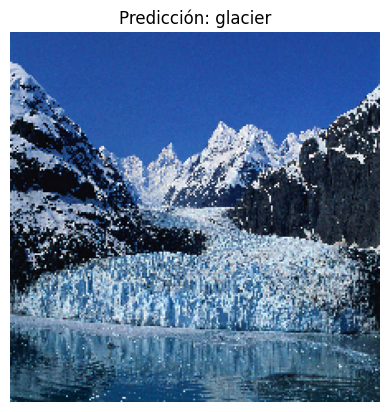

Predicción: glacier
Probabilidades:
  buildings : 0.000
  forest    : 0.000
  glacier   : 0.946
  mountain  : 0.051
  sea       : 0.002
  street    : 0.000


In [32]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

class_names = test_dt_transfer.class_names

def predict_image(model, img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    pred_label = class_names[class_idx]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicción: {pred_label}")
    plt.show()

    print(f"Predicción: {pred_label}")
    print("Probabilidades:")
    for i, name in enumerate(class_names):
        print(f"  {name:10s}: {preds[0][i]:.3f}")

uploaded = files.upload()
for fname in uploaded.keys():
    predict_image(model_tl, fname)


